# 1-C Nonlinear Covid-19 Epidemic Model and Prediction 

A Julia implementation of the following J-P Quadrat's papers:
- [1-C Nonlinear Covid-19 Epidemic Model and Application to the Epidemic Prediction in France](https://www.medrxiv.org/content/10.1101/2020.05.24.20111807v1)
- [A simple Covid-19 Epidemic Model and Containment Policy in France](https://www.medrxiv.org/content/10.1101/2020.04.25.20079434v1)

In [1]:
using HTTP, Plots, DifferentialEquations;

## Covid-19 Epidemic Model and Prediction of Daily-infected

In [2]:
# Signal derivation over days
# x: signal to derivate
# DT: delta time (unit: day)
#   DT=1 => daily
#   DT=7 => weekly
# Return the derived signal
function derivative(x, DT = 1)                
    M = size(x, 1);
    x0 = x[1:M-DT];
    x1 = x[1+DT:M];
    return (x1 .- x0) ./ DT;
end

derivative (generic function with 2 methods)

In [3]:
# Given r, get the a and b coefs of: a * log(accumul)^r + b
# where: cumulated is the total of daily cases (infected, death ... )
# Return a and b coefs and the initial value for the solver.
function model(cumulated, r)
    # Logarithm of accumulated infected people
    log_cumul = log.(cumulated)
    # Linear regression: y = a x + b
    x, y = log_cumul[1:end-1] .^ r, derivative(log_cumul)
    b, a = [ones(size(x, 1)) x] \ y
    return b, a, log_cumul[1]
end

model (generic function with 1 method)

In [4]:
# ODE
# f: function to solve
# u0: initial value of f(0)
# tend: number of days of observation
# days: number of days for prediction
function simulation(f::Function, u0, tend, days)
    tspan = (0.0, tend)
    prob = ODEProblem(f, u0, tspan)
    sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8)
    
    # Solution up to X days:
    tend = tend + days
    derivative(exp.(sol(1:tend)))
end

simulation (generic function with 1 method)

In [5]:
# Daily-infected prediction
# cumulative: accumulated cases.
# recovered: good estimated value is cumulative[end] from the previous wave
# r: a * log(accumul)^r + b (default: 1)
# days: estimation up to X days (default: 1 month)
# title: title of the plot
# position: position of the legend (default: top right)
function prediction(cumulative; recovered=0.0, r=1.0, days=30, title, position=:topright)
    S = size(cumulative, 1)
    b, a, u0 = model(cumulative .- recovered, r)
    f(u, p, t) = (u .^ r) .* a .+ b
    sim = simulation(f, u0, S, days)
    
    plot(derivative(cumulative),
        title = title,
        xlabel = "Days",
        ylabel = "Daily Infected",
        label = "observation",
        legend = position)
    plot!(sim, label="Prediction")
end

prediction (generic function with 1 method)

## Data extraction by country

In [6]:
# Load a CSV file and convert it as a dictionary structure where
# the dictionary keys are unique identifiers for country (ie name) and where
# the dictionary data are arrays of accumulated infected people over days.
#
# file: CSV file
# k: the CSV column id holding the key (ie country names)
# v: the CSV column id holding the accumulated infected people (total cases)
# Return the dictionary String => Vector{Float}
function load(file::AbstractString; k::Int, v::Int)
    dic = Dict{String, Array{Float64,1}}()
    open(file, "r") do data_file
        # Ignore the CSV header
        readline(data_file)
        # Ignore first data
        for row in 1:30
            readline(data_file)
        end
        # For each line of the CSV file ...
        rows = readlines(data_file)
        for row in rows
            # ... Extract columns
            entries = split(strip(row), ",")
            
            # Dictionary key: country identifier
            key = entries[k]
 
            # Dictionary values: convert string to float. Beware
            # some data are missing: in this case we copy the previous
            # non dummy data and when this not possible we use 0.0.
            val = 0.0
            if entries[v] != ""
                val = parse(Float64, entries[v])
            elseif haskey(dic, key)
                val = dic[key][end]
            end
            
            # Create a new if not existing, then append the new data
            if !haskey(dic, key)
                dic[key] = [val]
            else
                append!(dic[key], val)
            end
        end
    end
    dic
end

load (generic function with 1 method)

In [7]:
csv_file = HTTP.download("https://covid.ourworldindata.org/data/owid-covid-data.csv", update_period=Inf)

"/var/folders/nt/ttfj0ssj2k5_j58v_pqsdy9w0000gq/T/owid-covid-data.csv"

In [8]:
# Extract cumulative of daily cases by country
cumulative = load(csv_file, k=3, v=5)

Dict{String,Array{Float64,1}} with 192 entries:
  "Peru"               => [1.0, 1.0, 6.0, 7.0, 11.0, 11.0, 15.0, 28.0, 38.0, 43…
  "Indonesia"          => [2.0, 2.0, 2.0, 2.0, 4.0, 4.0, 6.0, 19.0, 27.0, 34.0 …
  "Gabon"              => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 4.0, 5.0, 5.0  … …
  "North Macedonia"    => [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0  … …
  "Bangladesh"         => [0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 3.0, 3.0, 3.0, 3.0  … …
  "Kosovo"             => [2.0, 5.0, 13.0, 16.0, 19.0, 20.0, 21.0, 24.0, 31.0, …
  "Tajikistan"         => [15.0, 15.0, 76.0, 128.0, 230.0, 293.0, 379.0, 461.0,…
  "Ethiopia"           => [1.0, 1.0, 1.0, 5.0, 5.0, 6.0, 6.0, 9.0, 9.0, 11.0  ……
  "Dominican Republic" => [1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 5.0, 5.0, 5.0  … …
  "South Sudan"        => [1.0, 1.0, 2.0, 2.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0  … …
  "Vietnam"            => [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 6.0  … …
  "Libya"              => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

In [9]:
# Fix France data with less noisy values. Data get from Fr governement 
cumulative["France"] = vcat(13, 18, 38, 57, 100, 130, 191, 212, 285, 423, 613, 949, 1126, 1412, 1784, 2281, 2876, 3661, 4500, 5423, 6633, 7730,
9134, 10995, 12612, 14459, 16689, 19856, 22302, 25233, 29155, 32964, 37575, 40174, 44450, 52128, 56989, 59105,
64338, 68605, 70478, 74390, 78167, 82048, 86334, 90676, 93790, 95403, 98076, 103573, 106206, 108847, 109252,
111821, 112606, 114657, 117324, 119151, 120804, 122577, 124114, 124575, 125770, 126835, 128442, 129581,
130185, 130979, 131287, 131863, 132967, 137150, 137779, 138421, 138854, 139063, 139519, 140227, 140734,
141356, 141919, 142291, 142411, 142903, 143427, 143845, 144163, 144566, 144806, 144921, 145279, 145555,
145746, 149071, 149668, 151496, 151753, 152091, 152225, 152325, 152444, 153055, 153634, 153977, 154188,
154591, 155136, 155561, 156287, 156813, 157220, 157372, 157716, 158174, 158641, 159452, 160093, 160277,
160750, 161267, 161348, 161648, 162936, 163454, 163980, 164260, 164801, 165719, 166378, 166960, 167711,
168159, 168335, 168810, 169473, 170094, 170752, 171504, 172089, 172377, 172888, 173304, 173838, 174674,
175639, 176404, 176754, 177338, 178336, 179398, 180528, 181528, 182528, 183079, 183804, 185196, 186573,
187919, 189547, 190739, 191295, 192334, 194029, 195633, 197921, 200105, 201990, 202775, 204172, 206696,
209365, 212211, 215521, 218536, 219029, 221267, 225043, 229814, 234400, 238002, 242899, 244854, 248158,
253587, 259698, 267077, 272530, 277943, 281025, 286007, 293024, 300182, 309156, 317706, 324777, 328980,
335524, 344101, 353944, 363350, 373911, 381094, 387252, 395104, 404888, 415481, 428696, 442194, 452763,
458061, 468069, 481141, 497237, 513034, 527546, 538569, 542639, 550690, 563535, 577505, 589653, 606625,
619190, 624274, 634763, 653509, 671638, 691977, 718873, 734974, 743479, 756472, 779063, 809684, 834770,
867197, 897034, 910277, 930475, 957421, 999043, 1041075, 1086497, 1138507, 1165278, 1198695, 1235132,
1282769, 1331984, 1367625, 1413915, 1466433, 1502763, 1543321, 1601367, 1661853, 1748705, 1787324,
1807479, 1829659, 1865538, 1898710, 1922504, 1954599, 1981827, 1991233, 2036755, 2065138, 2086288,
2109170, 2127051, 2140208, 2144660, 2153815, 2170097, 2183660, 2196119, 2208699, 2218483, 2222488,
2230571, 2244635, 2257331, 2268552, 2281475, 2292497, 2295908, 2309621, 2324216, 2337966, 2351372,
2365319, 2376852, 2379915, 2391447, 2409062, 2427316, 2442990, 2460555, 2473354, 2479151, 2490946);

## Simulations

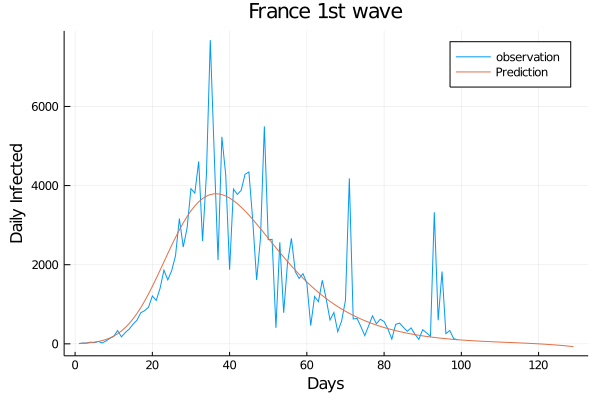

In [10]:
prediction(cumulative["France"][1:100], r=2.0, title="France 1st wave")

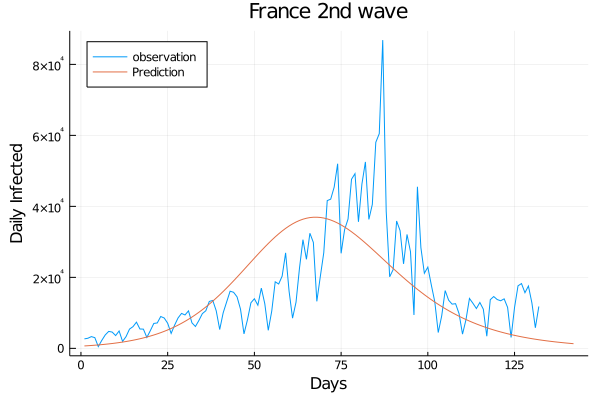

In [11]:
prediction(cumulative["France"][170:end], recovered=200000, r=10.0, days=10, title="France 2nd wave", position=:topleft)

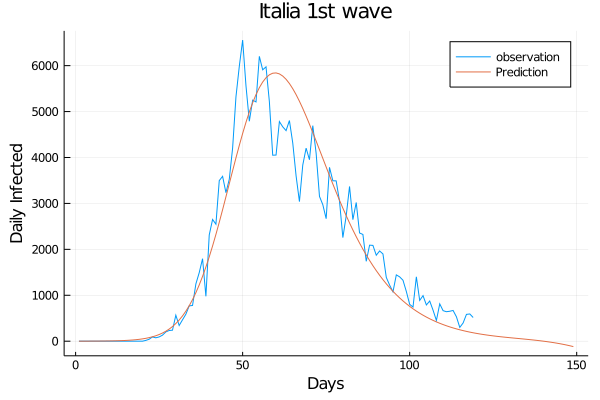

In [12]:
prediction(cumulative["Italy"][1:120], r=4.1, title="Italia 1st wave")

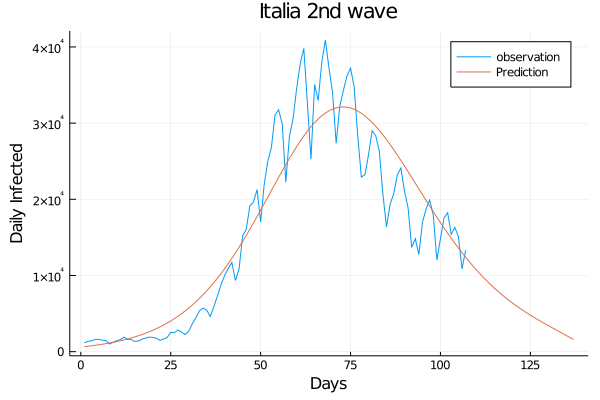

In [13]:
prediction(cumulative["Italy"][220:327], recovered=270000, r=11, title="Italia 2nd wave")

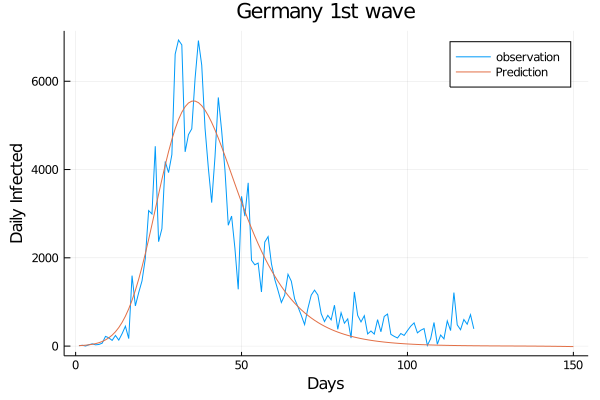

In [14]:
prediction(cumulative["Germany"][30:150], r=3.0, title="Germany 1st wave")

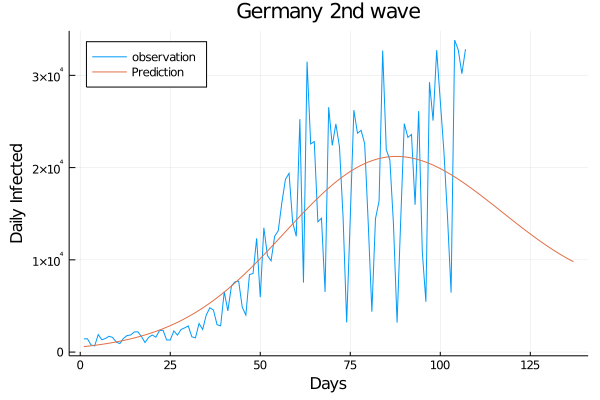

In [15]:
prediction(cumulative["Germany"][220:327], recovered=240000, r=7.0, title="Germany 2nd wave", position=:topleft)

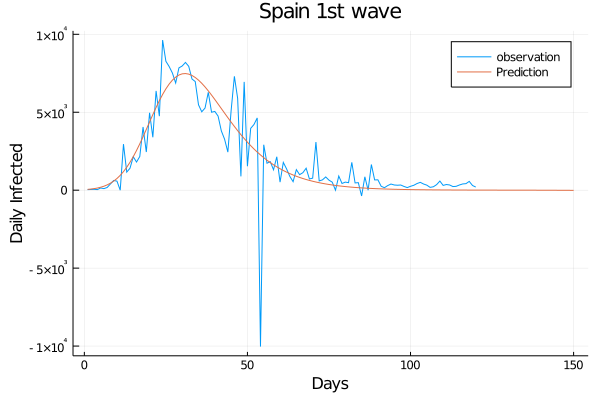

In [16]:
prediction(cumulative["Spain"][30:150], r=3.0, title="Spain 1st wave")

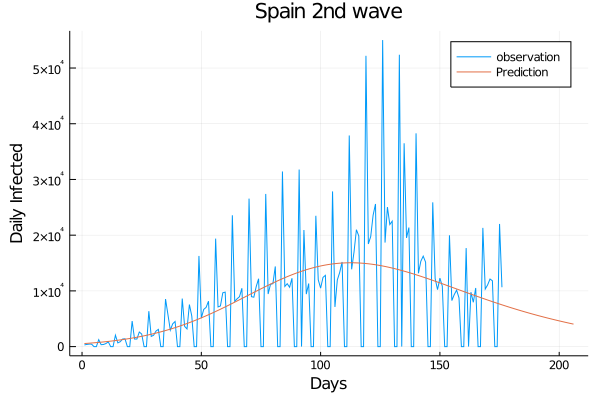

In [17]:
prediction(cumulative["Spain"][150:326], recovered=240000, r=6.0, title="Spain 2nd wave")

In [18]:
cumulative["Spain"][220]

525549.0

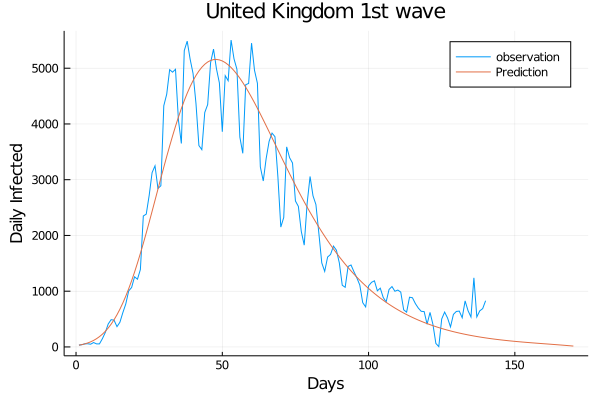

In [19]:
prediction(cumulative["United Kingdom"][30:170], r=1.5, title="United Kingdom 1st wave")

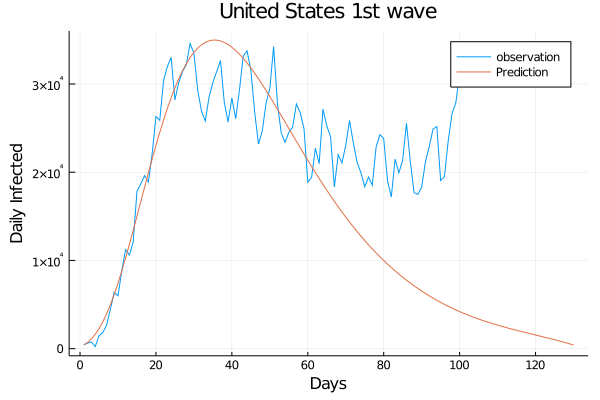

In [20]:
prediction(cumulative["United States"][50:150], recovered=1000, r=-0.7, title="United States 1st wave")

In [21]:
cumulative["United States"][120]

1.557933e6

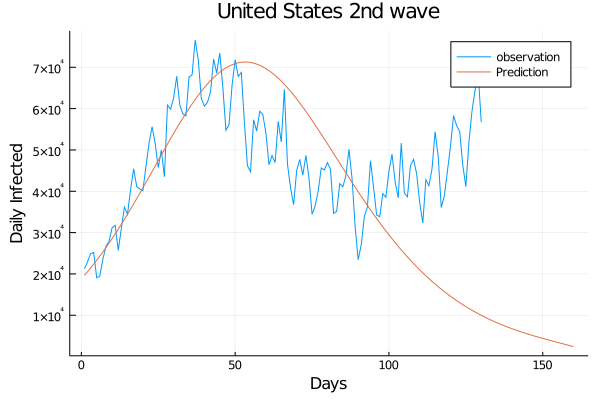

In [22]:
prediction(cumulative["United States"][140:270], recovered=1.6e6, r=12, title="United States 2nd wave")

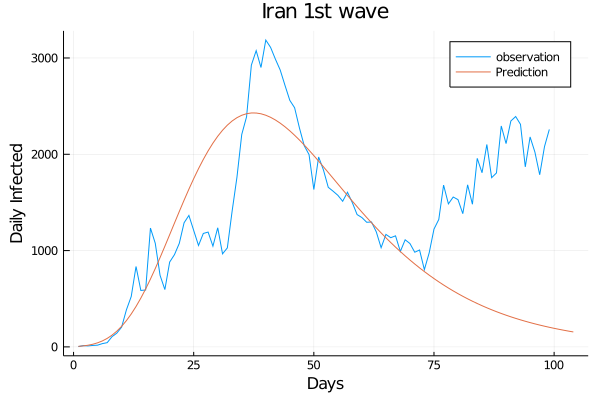

In [23]:
prediction(cumulative["Iran"][1:100], r=0.5, days=5, title="Iran 1st wave")

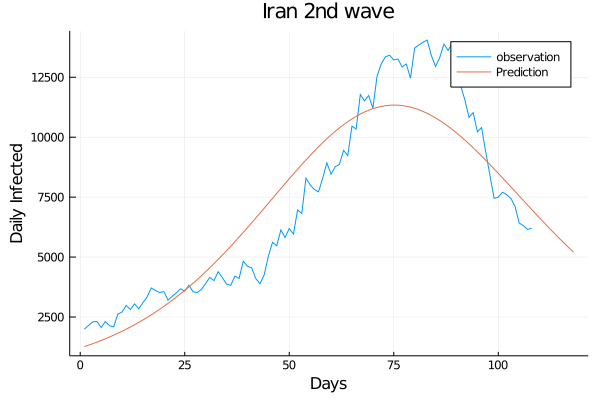

In [24]:
prediction(cumulative["Iran"][200:end], recovered=360000, r=12, days=10, title="Iran 2nd wave")

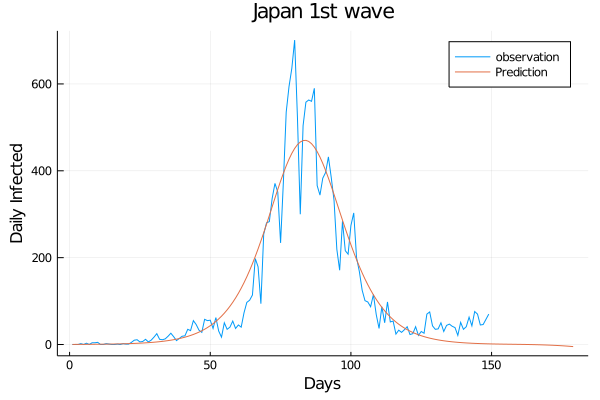

In [25]:
prediction(cumulative["Japan"][1:150], r=10.0, title="Japan 1st wave")

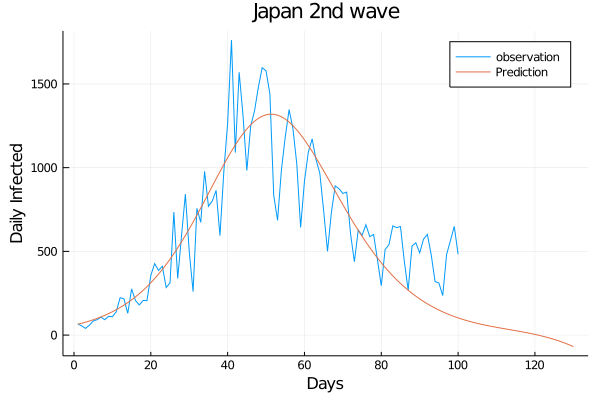

In [26]:
prediction(cumulative["Japan"][150:250], recovered=17000, r=10.0, title="Japan 2nd wave")

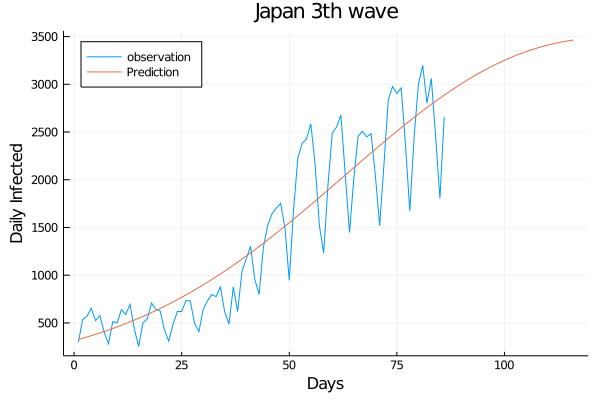

In [27]:
prediction(cumulative["Japan"][250:end], recovered=75000, r=5.0, title="Japan 3th wave", position=:topleft)

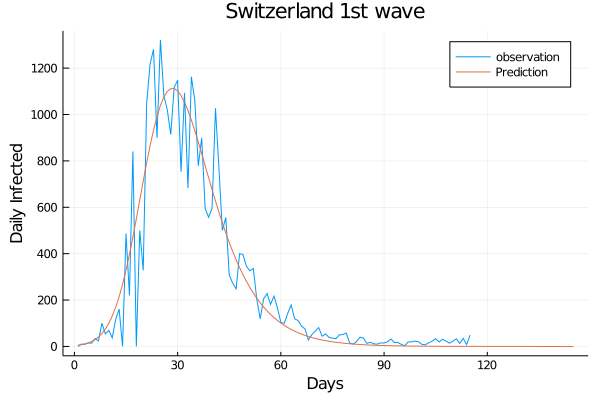

In [28]:
prediction(cumulative["Switzerland"][35:150], r=3.0, title="Switzerland 1st wave")

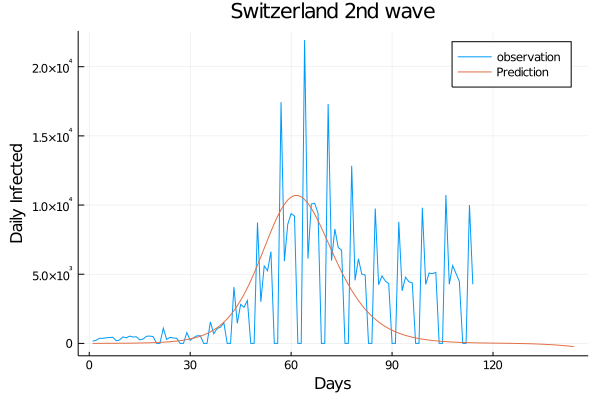

In [29]:
prediction(cumulative["Switzerland"][220:end], recovered=42000, r=10.0, title="Switzerland 2nd wave")

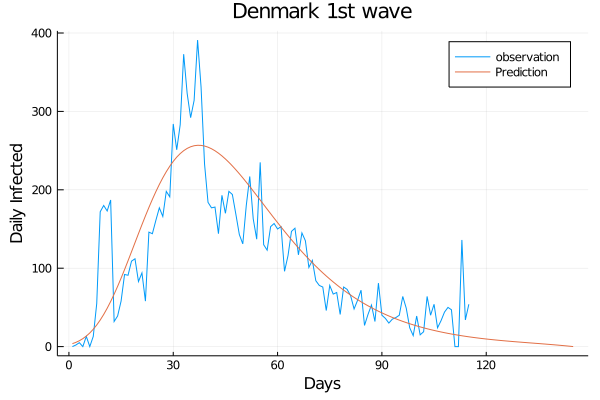

In [30]:
prediction(cumulative["Denmark"][35:150], r=0.7, title="Denmark 1st wave")

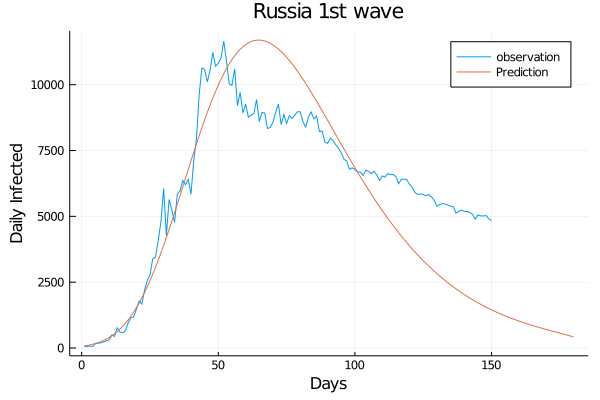

In [31]:
prediction(cumulative["Russia"][50:200], r=1.7, title="Russia 1st wave")

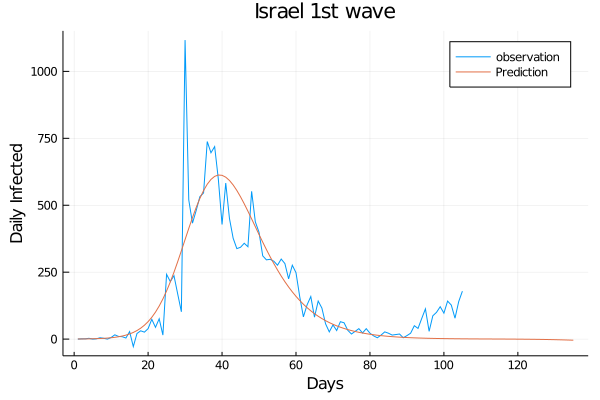

In [32]:
prediction(cumulative["Israel"][30:135], r=4.0, title="Israel 1st wave")

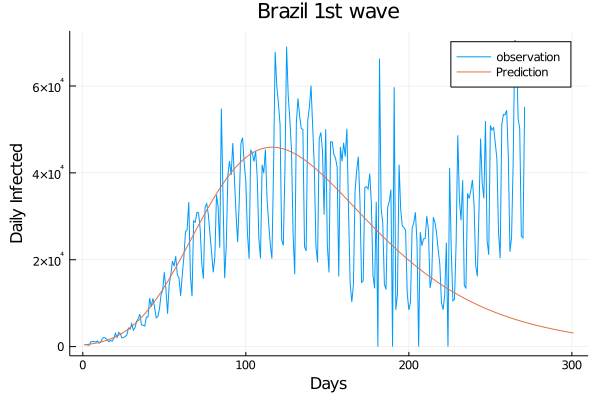

In [33]:
prediction(cumulative["Brazil"][30:end], r=2, title="Brazil 1st wave")

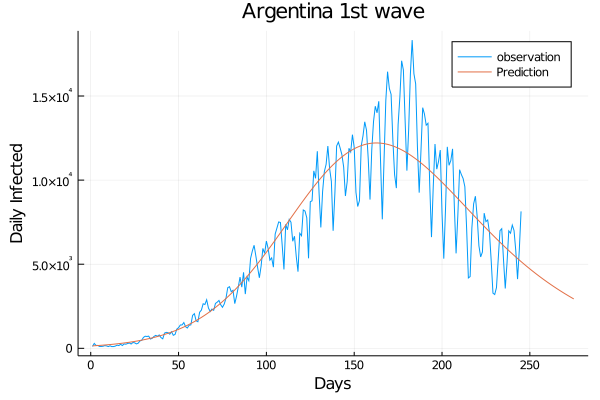

In [34]:
prediction(cumulative["Argentina"][80:end], r=7, title="Argentina 1st wave")

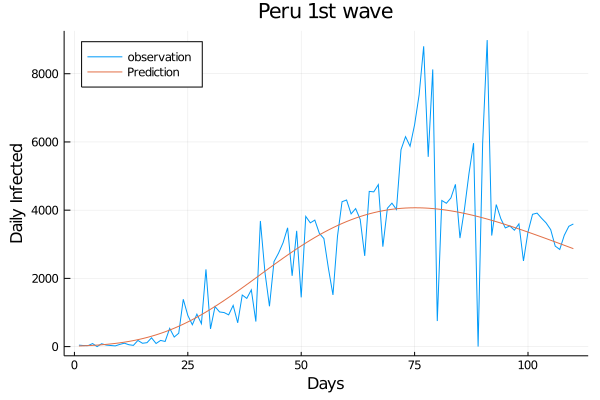

In [35]:
prediction(cumulative["Peru"][10:120], r=0.7, days=0, title="Peru 1st wave", position=:topleft)

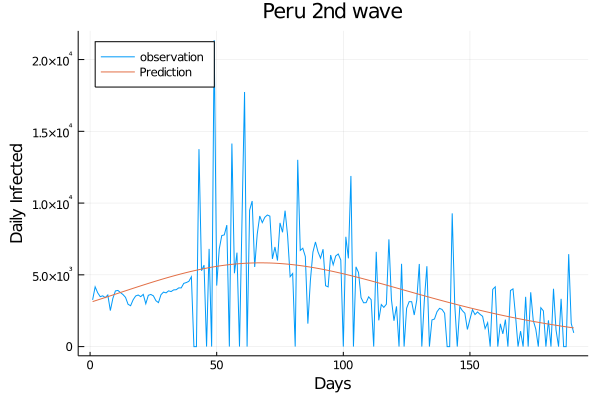

In [36]:
prediction(cumulative["Peru"][101:end], recovered=100000, r=10, days=0, title="Peru 2nd wave", position=:topleft)

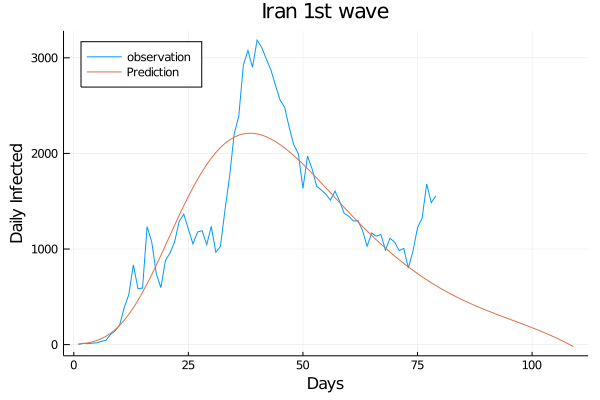

In [37]:
prediction(cumulative["Iran"][1:80], r=0.4, title="Iran 1st wave", position=:topleft)

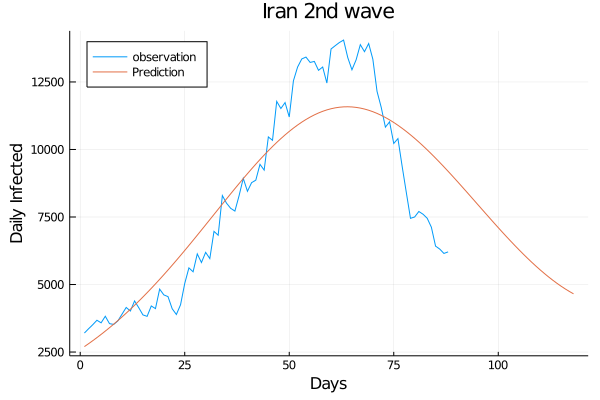

In [38]:
prediction(cumulative["Iran"][220:end], recovered=380000, r=12, title="Iran 2nd wave", position=:topleft)

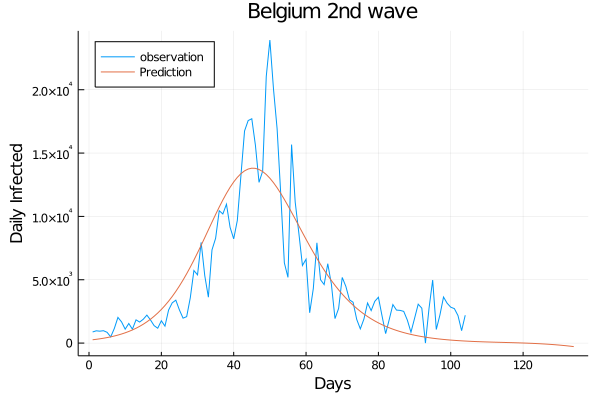

In [39]:
prediction(cumulative["Belgium"][220:end], recovered=88000, r=10, title="Belgium 2nd wave", position=:topleft)

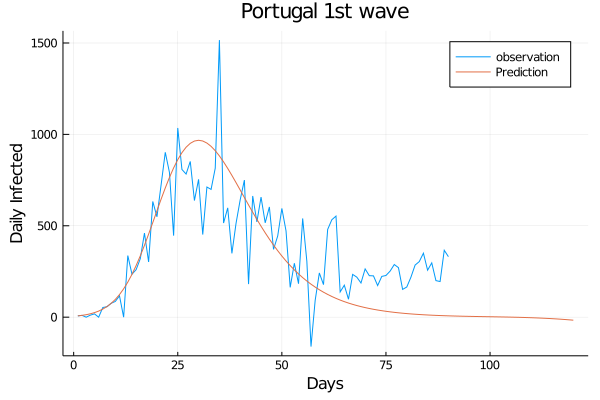

In [40]:
prediction(cumulative["Portugal"][10:100], r=3, title="Portugal 1st wave")

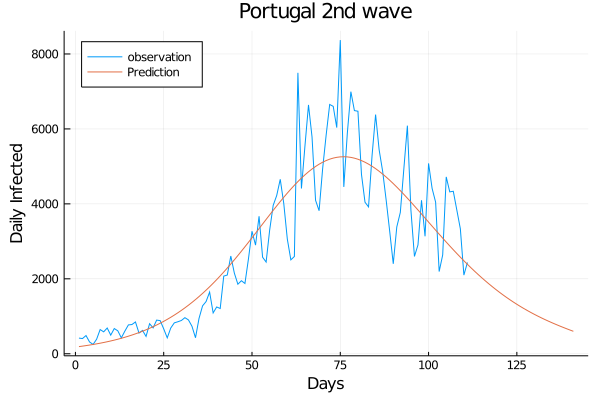

In [41]:
prediction(cumulative["Portugal"][190:end], recovered=56000, r=10, title="Portugal 2nd wave", position=:topleft)

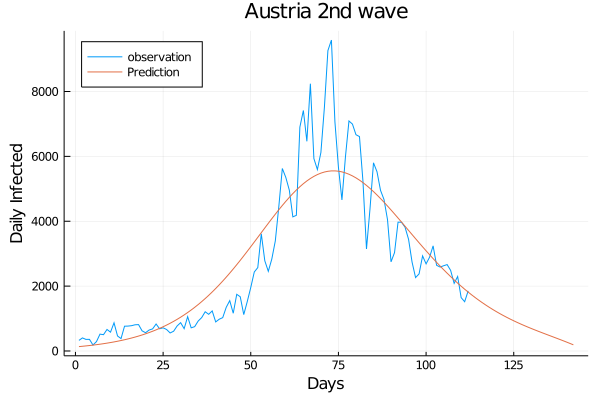

In [42]:
prediction(cumulative["Austria"][190:end], recovered=26000, r=10, title="Austria 2nd wave", position=:topleft)

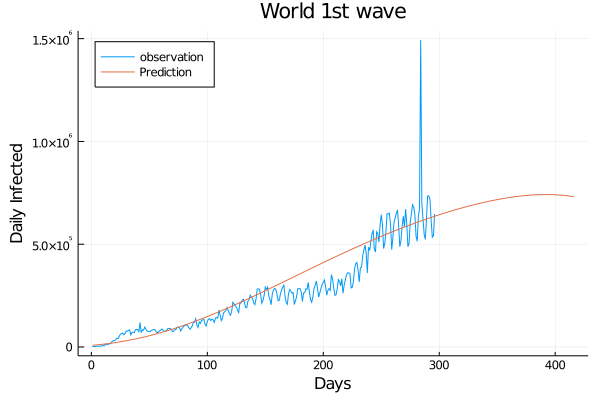

In [43]:
prediction(cumulative["World"][40:end], r=-2.7, days=120, title="World 1st wave", position=:topleft)